In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from cv2 import imread,imwrite,resize
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras
import math
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load dataset function
def load_data(root):
    dict_img = {}
    for dir in os.listdir(root):
        img = Image.open(os.path.join(root, dir, os.listdir(os.path.join(root, dir))[0]))
        print(img.size)
        dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
    return dict_img


In [ ]:
#plot sample from dataset function
def plot_first_img_from_each_dir(root):
  dict_img = load_data(root)
  fig, ax = plt.subplots(1, len(dict_img), figsize=(10, 5))
  for i, dir in enumerate(dict_img):
    img = Image.open(os.path.join(root, dir, os.listdir(os.path.join(root, dir))[0]))
    ax[i].imshow(img)
    ax[i].set_title(dir)
  plt.show()


In [ ]:
#load original dataset
root =  '/content/drive/MyDrive/dataset'


(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)


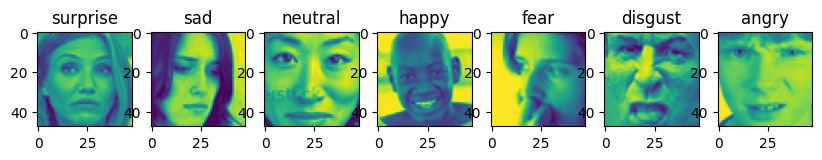

In [ ]:
#plot first image from each directory
plot_first_img_from_each_dir(root)

In [ ]:
#  copy from dataset and resize images of all folders and convert to gray
new_root = '/content/drive/MyDrive/dataset_new'

for dir in load_data(root):
  os.makedirs(os.path.join(new_root, dir), exist_ok=True)
  for img_name in os.listdir(os.path.join(root, dir)):
    img = imread(os.path.join(root, dir, img_name))
    new_img = resize(img, (250, 250))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    imwrite(os.path.join(new_root, dir, img_name), new_img)


(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


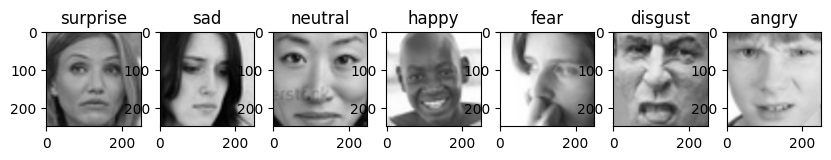

In [ ]:
plot_first_img_from_each_dir(new_root)

In [ ]:
sized="/content/drive/MyDrive/dataset_new"
def enhance_images(root):
  new_root = '/content/drive/MyDrive/dataset_new_enhanced'
  for dir in load_data(root):
    os.makedirs(os.path.join(new_root, dir), exist_ok=True)
    for img_name in os.listdir(os.path.join(root, dir)):
      img = imread(os.path.join(root, dir, img_name))
      #convert to grayscale
      gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #remove blur
      kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
      sharpened = cv2.filter2D(gray_img, -1, kernel)
      #convert back to rgb
      new_img = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2RGB)
      imwrite(os.path.join(new_root, dir, img_name), new_img)

#call function to enhance images
enhance_images(new_root)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


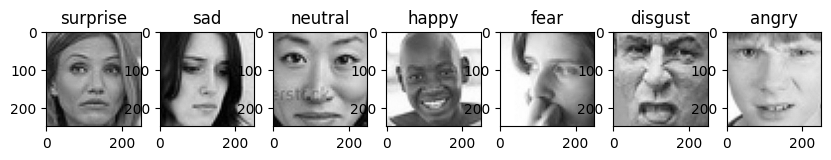

In [ ]:
plot_first_img_from_each_dir('/content/drive/MyDrive/dataset_new_enhanced')

In [ ]:
from PIL import Image
import os

def normalize_images_in_directory(directory_path):
    # Check if the directory path exists
    if not os.path.exists(directory_path):
        print("Directory path does not exist.")
        return None

    # List all files in the directory
    files = os.listdir(directory_path)

    # Iterate through each file in the directory
    for file_name in files:
        file_path = os.path.join(directory_path, file_name)

        # Check if the file is an image file (you can modify this check based on your image formats)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            # Open the image using PIL
            img = Image.open(file_path)

            # Normalize pixel values (convert to range [0, 1])
            img = img.convert('RGB')  # Convert image to RGB mode if not already
            img_array = np.array(img)
            img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

            # Save the normalized image back to the file
            img_normalized = Image.fromarray((img_array * 255).astype('uint8'))
            img_normalized.save(file_path)

    print("Normalization completed for all image files in the directory.")

# Replace 'directory_path' with the path to your directory containing image files
directory_path = '/content/drive/MyDrive/dataset_new_enhanced'

# Apply normalization to images in the specified directory
normalize_images_in_directory(directory_path)


Normalization completed for all image files in the directory.


In [ ]:
import os
from sklearn.preprocessing import LabelEncoder

def label_encode_image_data(directory_path):
    # Check if the directory path exists
    if not os.path.exists(directory_path):
        print("Directory path does not exist.")
        return None

    # Get the list of subdirectories (assuming each subdirectory represents a different facial expression)
    facial_expressions = sorted([d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))])

    # Initialize a LabelEncoder
    label_encoder = LabelEncoder()

    # Fit label encoder on facial expression labels
    label_encoder.fit(facial_expressions)

    # Print the mapping of facial expressions to encoded labels
    print("Facial expressions to encoded labels mapping:")
    for i, expression in enumerate(label_encoder.classes_):
        print(f"{expression} -> {i}")

    # Return the label encoder
    return label_encoder

directory_path = '/content/drive/MyDrive/dataset_new_enhanced'

# Apply label encoding to facial expression labels in the specified directory
label_encoder = label_encode_image_data(directory_path)


Facial expressions to encoded labels mapping:
angry -> 0
disgust -> 1
fear -> 2
happy -> 3
neutral -> 4
sad -> 5
surprise -> 6


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def augment_image_data(directory_path, output_path, augment_params):
    # Check if the input directory path exists
    if not os.path.exists(directory_path):
        print("Input directory path does not exist.")
        return

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(**augment_params)

    # Flow and augment images from the input directory and save them to the output directory
    image_generator = datagen.flow_from_directory(
        directory=directory_path,
        target_size=(224, 224),  # Adjust the target size as needed
        batch_size=32,           # Adjust batch size as needed
        class_mode='categorical',  # Change class mode based on the problem (binary, categorical, etc.)
        save_to_dir=output_path,  # Output directory to save augmented images
        save_prefix='augmented_',  # Prefix for the filenames of augmented images
        save_format='png'  # Output image format
    )

    # Generate and save augmented images
    num_images = 5  # Number of augmented images to generate per original image
    for i, _ in enumerate(image_generator):
        if i >= num_images:
            break  # Stop after generating the specified number of images

# Replace 'directory_path' with the path to your directory containing original images
input_directory_path = '/content/drive/MyDrive/dataset_new_enhanced'

# Replace 'output_path' with the path to the directory to save augmented images
output_directory_path = '/content/drive/MyDrive/data_aug'

# Augmentation parameters (adjust as needed)
augmentation_parameters = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'brightness_range': (0.8, 1.2)
}

# Apply data augmentation
augment_image_data(input_directory_path, output_directory_path, augmentation_parameters)


Found 700 images belonging to 7 classes.


In [ ]:
# perfect segmentation function by findContours
def perfect_segmentation(root):
  new_root = '/content/drive/MyDrive/dataset_new_segmented'
  for dir in load_data(root):
    os.makedirs(os.path.join(new_root, dir), exist_ok=True)
    for img_name in os.listdir(os.path.join(root, dir)):
      img = imread(os.path.join(root, dir, img_name))
      #convert to grayscale
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      #apply thresholding
      ret, thresh = cv2.threshold(gray_img, 127, 255, 0)
      #find contours
      contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      #draw contours on image
      cv2.drawContours(img, contours, -1, (255, 0, 0), 3)
      imwrite(os.path.join(new_root, dir, img_name), img)

#call function to segment images
perfect_segmentation(new_root)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


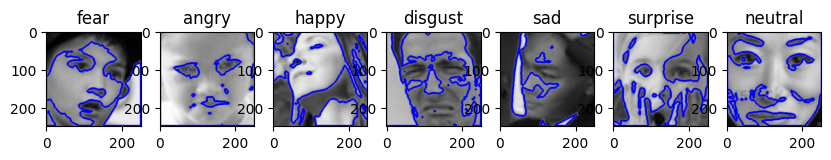

In [ ]:
plot_first_img_from_each_dir('/content/drive/MyDrive/dataset_new_segmented')

In [ ]:
# feature extraction using GLCM

new_root = '/content/drive/MyDrive/dataset_new_segmented'
def extract_features(root):
  features = []
  labels = []
  for dir in load_data(root):
    for img_name in os.listdir(os.path.join(root, dir)):
      img = imread(os.path.join(root, dir, img_name))
      #convert to grayscale
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      #compute GLCM
      glcm = graycomatrix(gray_img, [1], [0], 256)
      #compute features
      features.append(graycoprops(glcm, 'contrast'))
      labels.append(dir)
  return features, labels

#extract features
features, labels = extract_features(new_root)

#save features and labels to csv file
features = np.array(features).reshape((700, 1))
df = pd.DataFrame(features)
df['label'] = labels
df.to_csv('features.csv', index=False)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


In [ ]:
# feature extraction using SIFT
new_root = '/content/drive/MyDrive/dataset_new_segmented'

def extract_features(root):
  features = []
  labels = []
  for dir in load_data(root):
    for img_name in os.listdir(os.path.join(root, dir)):
      img = imread(os.path.join(root, dir, img_name))
      #convert to grayscale
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      #compute SIFT features
      sift = cv2.SIFT_create()
      keypoints, descriptors = sift.detectAndCompute(gray_img, None)
      #add features and labels to list
      features.append(descriptors)
      labels.append(dir)
  return features, labels

#extract features
features, labels = extract_features(new_root)

#save features and labels to csv file
features = np.array(features)
df = pd.DataFrame(features)
df['label'] = labels
df.to_csv('features_sift.csv', index=False)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


<ipython-input-15-cc2f09020a80>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


In [ ]:
# prompt: find interest points on all images in segmented dataset and save result in new dataset

new_root = '/content/drive/MyDrive/dataset_new_segmented'
def extract_features(root):
  new_root = '/content/drive/MyDrive/dataset_new_segmented_interest_points'
  for dir in load_data(root):
    os.makedirs(os.path.join(new_root, dir), exist_ok=True)
    for img_name in os.listdir(os.path.join(root, dir)):
      img = imread(os.path.join(root, dir, img_name))
      #convert to grayscale
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      #compute SIFT features
      sift = cv2.SIFT_create()
      keypoints, descriptors = sift.detectAndCompute(gray_img, None)
      #draw keypoints on image
      img = cv2.drawKeypoints(gray_img, keypoints, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      imwrite(os.path.join(new_root, dir, img_name), img)

#extract features
extract_features(new_root)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)


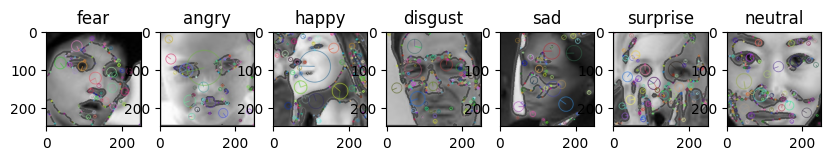

In [ ]:
plot_first_img_from_each_dir('/content/drive/MyDrive/dataset_new_segmented_interest_points')

In [ ]:
root =  '/content/drive/MyDrive/dataset_new_segmented_interest_points'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img


{'fear': 100,
 'angry': 100,
 'happy': 100,
 'disgust': 100,
 'sad': 100,
 'surprise': 100,
 'neutral': 100}

In [ ]:
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [ ]:
create_folders('T_sample', 0.7)

In [ ]:
create_folders('test', 0.15)

In [ ]:
create_folders('val', 0.15)

In [ ]:
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

count_img('T_sample')

{'angry': 70,
 'happy': 70,
 'fear': 70,
 'neutral': 70,
 'surprise': 70,
 'disgust': 70,
 'sad': 70}

In [ ]:
count_img('test')

{'angry': 15,
 'happy': 15,
 'fear': 15,
 'neutral': 15,
 'surprise': 15,
 'disgust': 15,
 'sad': 15}

In [ ]:
count_img('val')

{'angry': 15,
 'happy': 15,
 'fear': 15,
 'neutral': 15,
 'surprise': 15,
 'disgust': 15,
 'sad': 15}

In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    label_dict = {os.path.basename(directory): i for i, directory in enumerate(dir_list)}



    for directory in dir_list:
        label = label_dict[os.path.basename(directory)]  # Get numerical label for the directory
        for filename in os.listdir(directory):
            image = cv2.imread(os.path.join(directory, filename))
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y, random_state=42)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/T_sample/angry', '/content/T_sample/disgust','/content/T_sample/fear','/content/T_sample/happy','/content/T_sample/neutral','/content/T_sample/sad','/content/T_sample/surprise'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 490
X shape is: (490, 240, 240, 3)
y shape is: (490,)


In [ ]:
import matplotlib.pyplot as plt

def plot_sample_images(X, y, n=40):
    label_to_str = {
        0: 'angry',
        1: 'disgust',
        2: 'fear',
        3: 'happy',
        4: 'neutral',
        5: 'sad',
        6: 'surprise'
    }

    for label in range(7):  # Loop through 7 labels
        images = X[y == label][:n]  # Grab the first n images for the current label

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(10, 8))

        for i, image in enumerate(images, 1):
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image)

            # Remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.suptitle(f"Feeling: {label_to_str[label]}")
        plt.show()


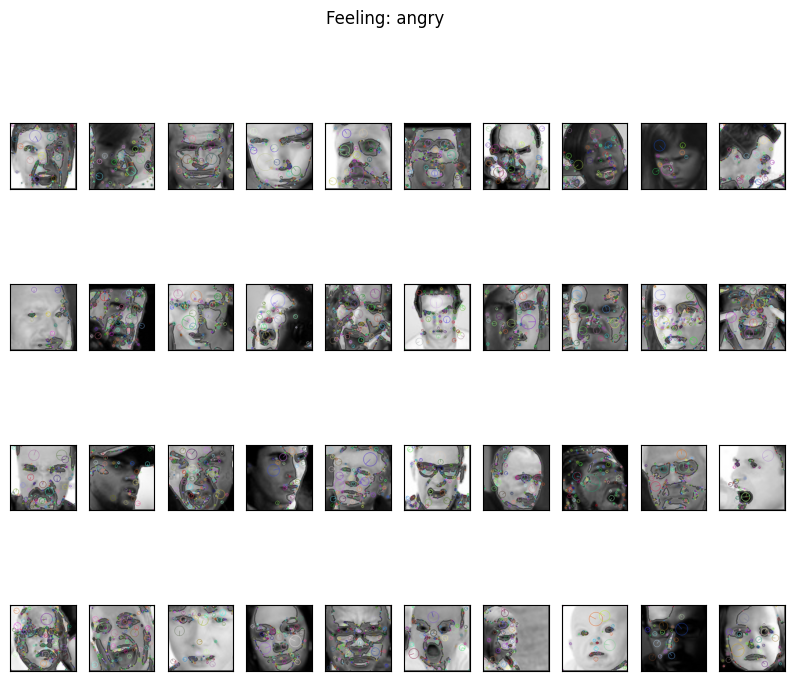

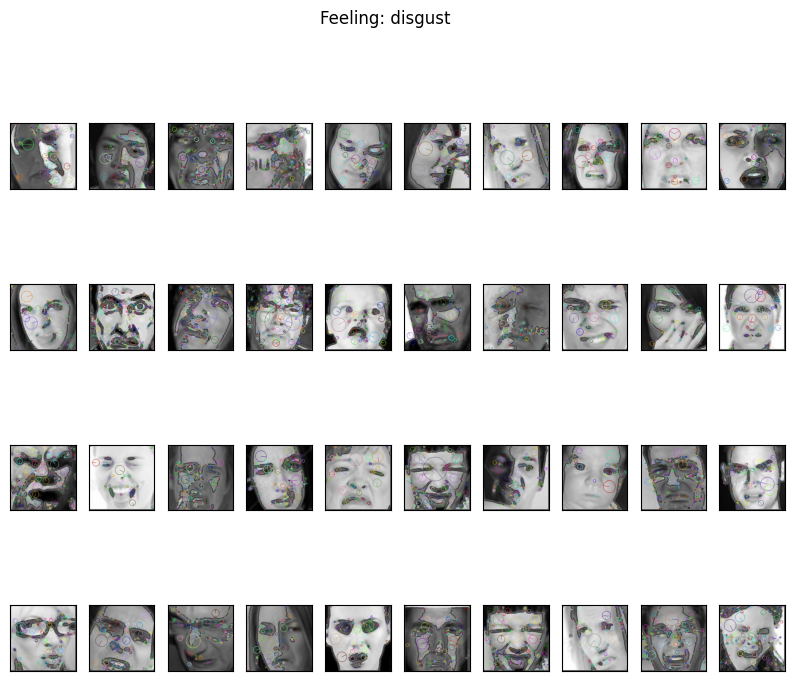

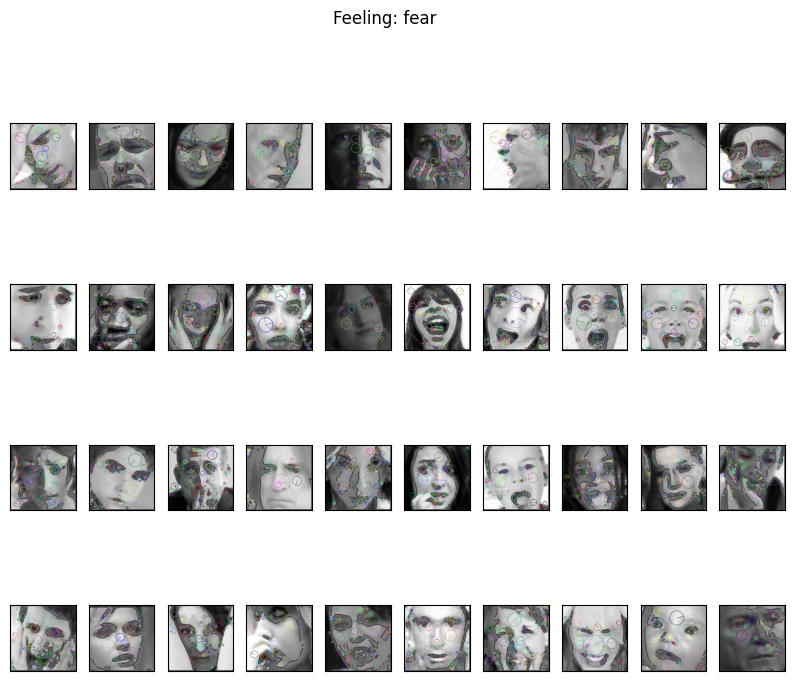

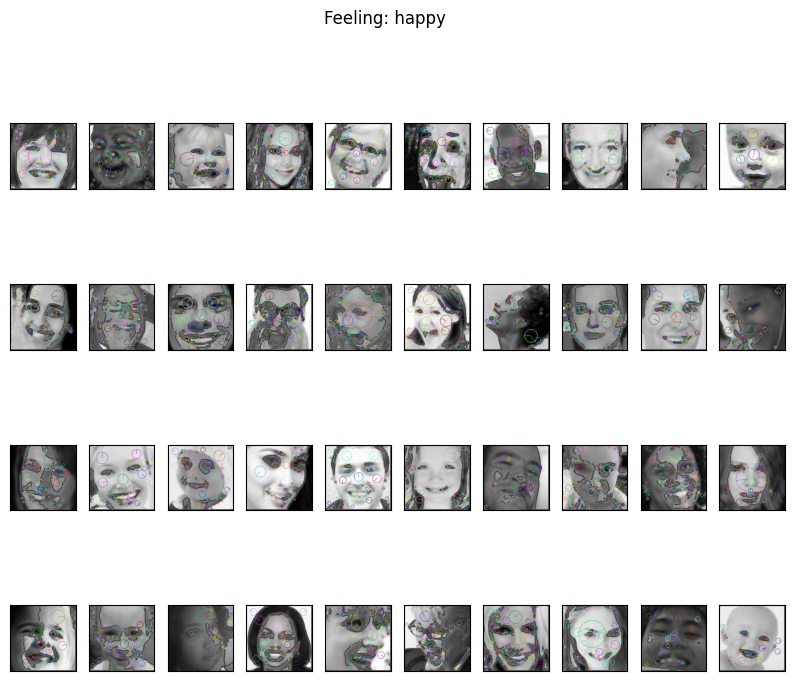

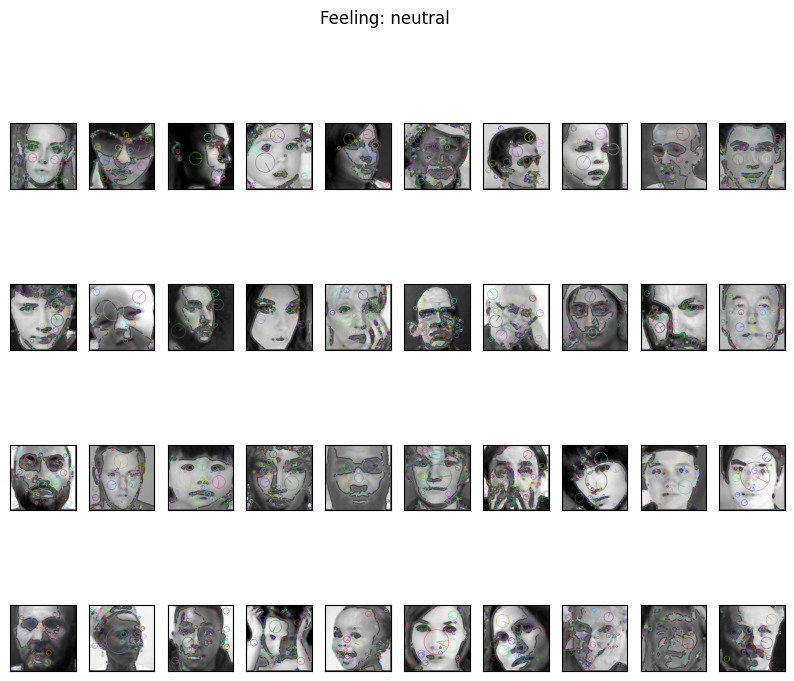

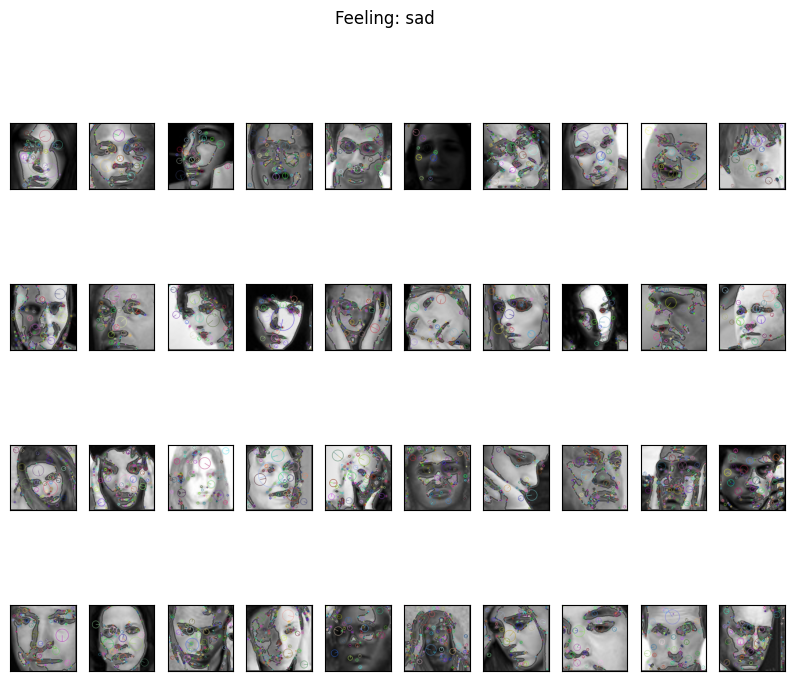

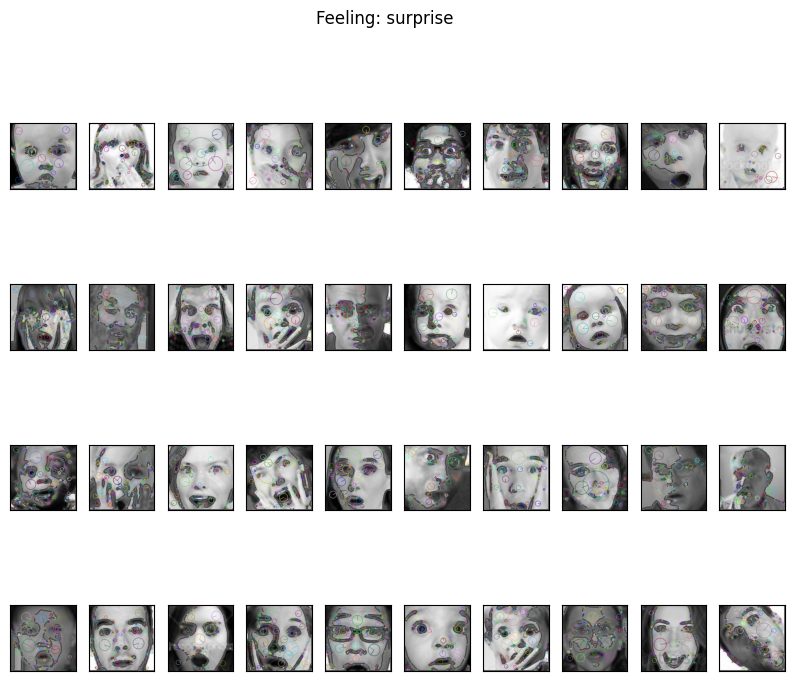

In [ ]:
plot_sample_images(X_train, y_train)

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/angry', '/content/test/disgust','/content/test/fear','/content/test/happy','/content/test/neutral','/content/test/sad','/content/test/surprise'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 105
X shape is: (105, 240, 240, 3)
y shape is: (105,)


In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/angry', '/content/val/disgust','/content/val/fear','/content/val/happy','/content/val/neutral','/content/val/sad','/content/val/surprise'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 105
X shape is: (105, 240, 240, 3)
y shape is: (105,)


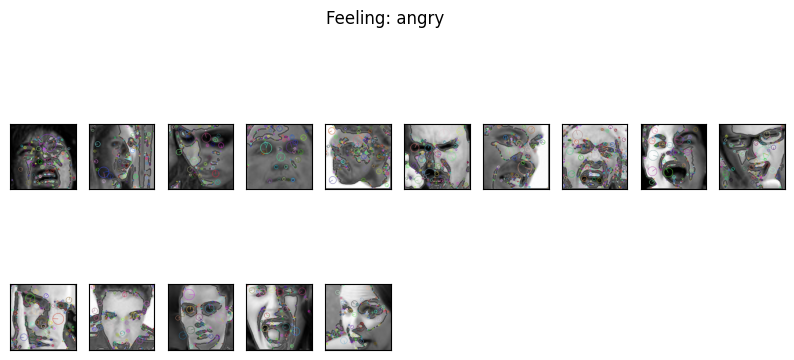

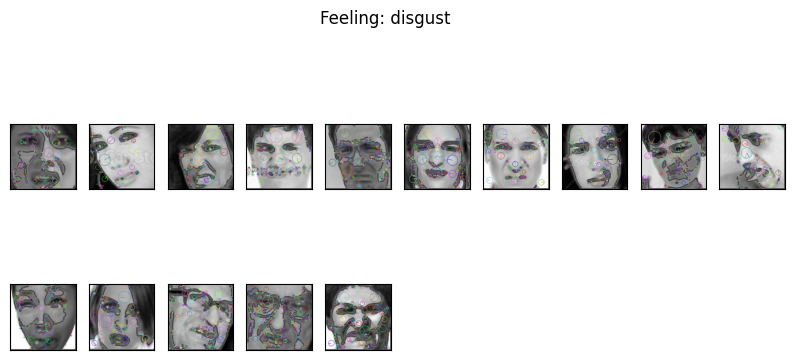

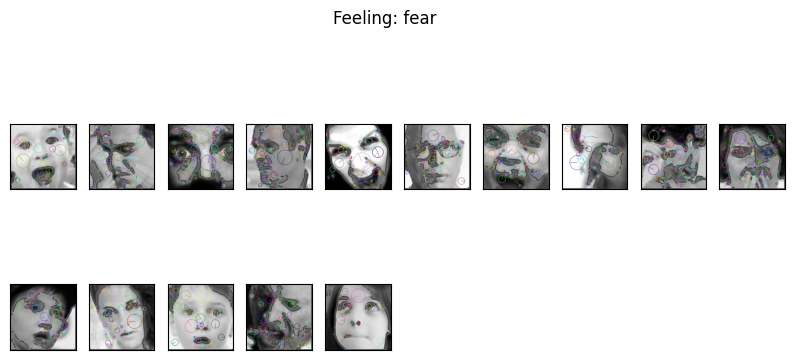

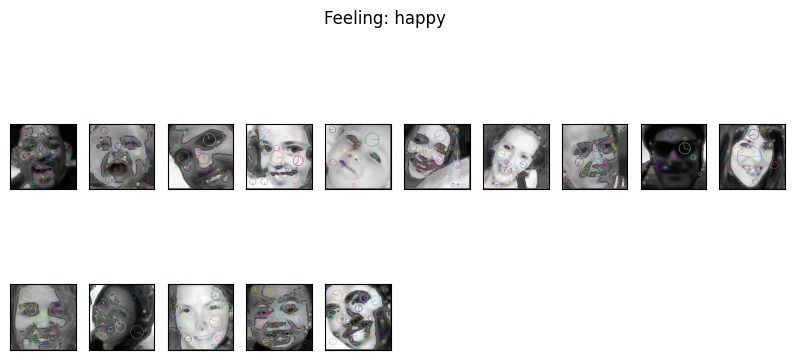

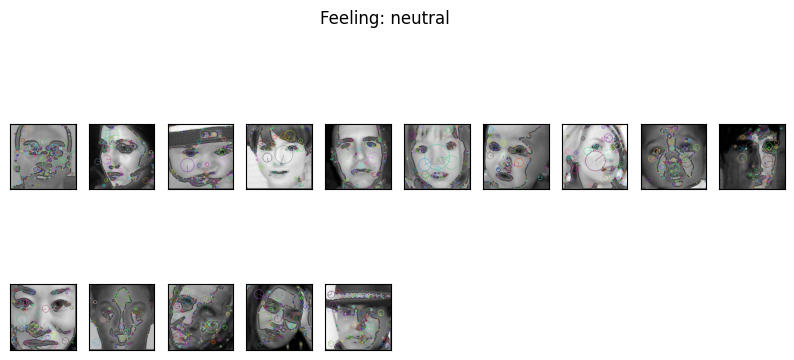

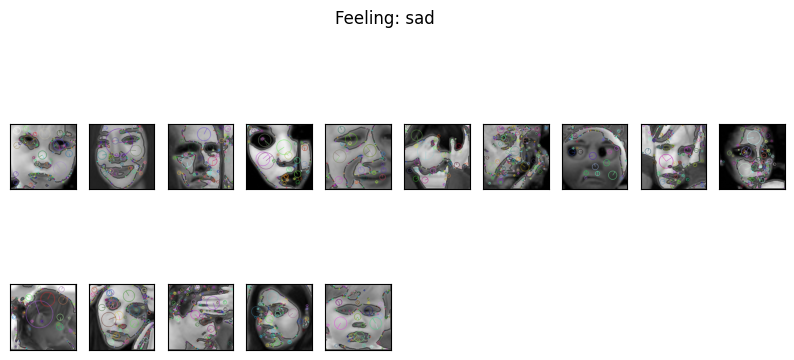

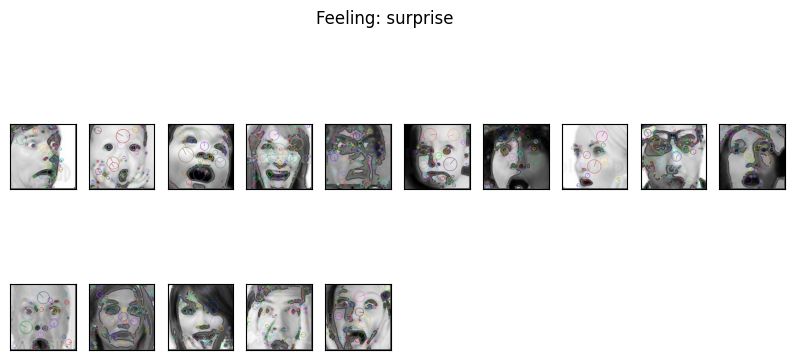

In [ ]:
plot_sample_images(X_val, y_val)

In [ ]:
train = "/content/T_sample"
train_names =[]
train_names =[f for f in sorted(os.listdir(train))]
print(len(train_names))

7


In [ ]:
validation = "/content/val"
validation_names =[]
validation_names = [f for f in sorted(os.listdir(validation))]
print(len(validation_names))

7


In [ ]:
print("Categories:")
for i in train_names:
    print(i)

Categories:
angry
disgust
fear
happy
neutral
sad
surprise


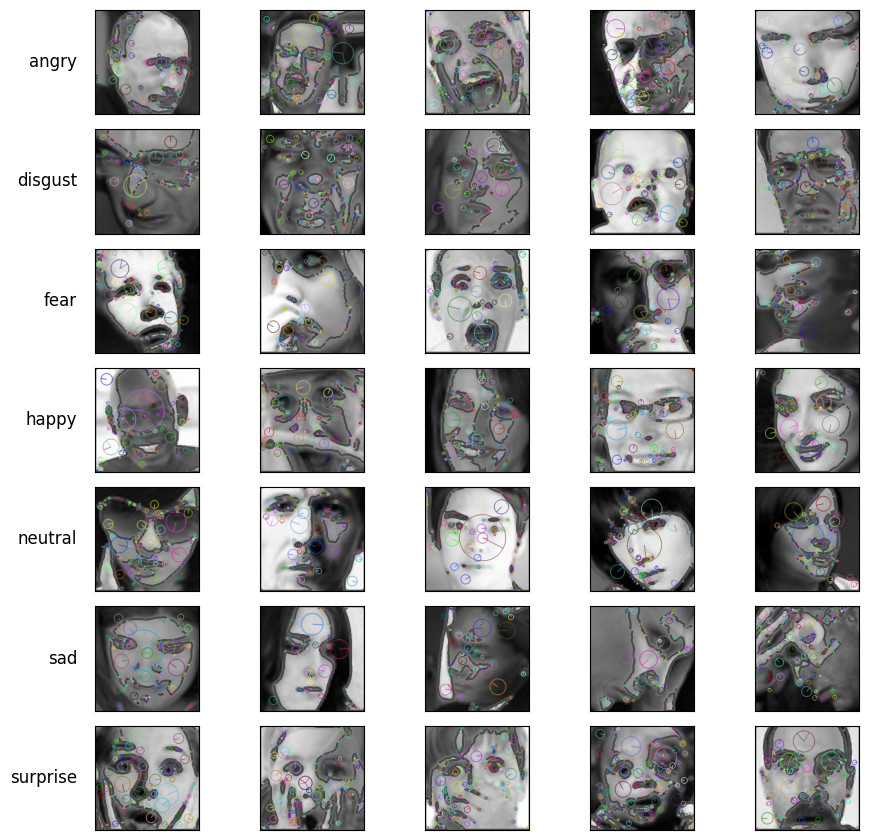

In [ ]:
fig,ax = plt.subplots(nrows=7,ncols=5)
fig.set_size_inches(9.5,8.5)
fig.subplots_adjust(wspace=0.1,hspace=0.1)

for i in range(len(train_names)):
    folder_path = train + '/' + str(train_names[i])
    image_names = [img for img in sorted(os.listdir(folder_path))][:5]

    for j in range(len(image_names)):
        image_path = folder_path + '/' + image_names[j]
        image = cv2.imread(image_path)
        ax[i,j].imshow(image)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if j == 0:
            ax[i,j].annotate(train_names[i], xy=(0, 0.5), xytext=(-ax[i,j].yaxis.labelpad - 5,0),
                xycoords=ax[i,j].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()

In [ ]:
category_dict = {}
images_per_category_dict = {}
category_images_path_dict = {}

total_images = 0

for i in range(len(train_names)):
    folder_path = train + '/' + str(train_names[i])
    category_dict[i] = train_names[i]

    image_names = [img for img in sorted(os.listdir(folder_path))]

    images_per_category_dict[i] = len(image_names)
    category_images_path_dict[i] = image_names

    print('%s: %d' %(train_names[i], images_per_category_dict[i]))
    total_images += images_per_category_dict[i]

print('Total images in training data: %d' %(total_images))

angry: 70
disgust: 70
fear: 70
happy: 70
neutral: 70
sad: 70
surprise: 70
Total images in training data: 490


In [ ]:
category_dict = {}
images_per_category_dict = {}
category_images_path_dict = {}

total_images = 0

for i in range(len(validation_names)):
    folder_path = validation + '/' + str(validation_names[i])
    category_dict[i] = validation_names[i]

    image_names = [img for img in sorted(os.listdir(folder_path))]

    images_per_category_dict[i] = len(image_names)
    category_images_path_dict[i] = image_names

    print('%s: %d' %(validation_names[i], images_per_category_dict[i]))
    total_images += images_per_category_dict[i]

print('Total images in validation data: %d' %(total_images))


angry: 15
disgust: 15
fear: 15
happy: 15
neutral: 15
sad: 15
surprise: 15
Total images in validation data: 105


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(48,48),
    batch_size=128,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation,
        target_size=(48, 48),
        batch_size=128,
        class_mode='categorical')

Found 490 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


In [ ]:
from keras import layers
from keras import  models

model =models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(48,48,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(7,activation='softmax'))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [ ]:
from keras import  optimizers
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_loss',patience =10,verbose=1)
history = model.fit(train_generator,epochs=100,validation_data=validation_generator,
                   verbose=1,callbacks=earlystopping)

Epoch 1/100
4/4 [==============================] - 3s 565ms/step - loss: 1.9501 - accuracy: 0.1327 - val_loss: 1.9458 - val_accuracy: 0.1429
Epoch 2/100
4/4 [==============================] - 2s 395ms/step - loss: 1.9462 - accuracy: 0.1449 - val_loss: 1.9450 - val_accuracy: 0.1333
Epoch 3/100
4/4 [==============================] - 1s 325ms/step - loss: 1.9444 - accuracy: 0.1490 - val_loss: 1.9451 - val_accuracy: 0.1524
Epoch 4/100
4/4 [==============================] - 1s 324ms/step - loss: 1.9428 - accuracy: 0.1714 - val_loss: 1.9449 - val_accuracy: 0.1810
Epoch 5/100
4/4 [==============================] - 1s 358ms/step - loss: 1.9420 - accuracy: 0.1898 - val_loss: 1.9447 - val_accuracy: 0.1810
Epoch 6/100
4/4 [==============================] - 1s 335ms/step - loss: 1.9411 - accuracy: 0.1898 - val_loss: 1.9444 - val_accuracy: 0.1714
Epoch 7/100
4/4 [==============================] - 2s 327ms/step - loss: 1.9401 - accuracy: 0.2224 - val_loss: 1.9440 - val_accuracy: 0.1905
Epoch 8/100
4

1/1 [==============================] - 0s 98ms/step
predict class: fear


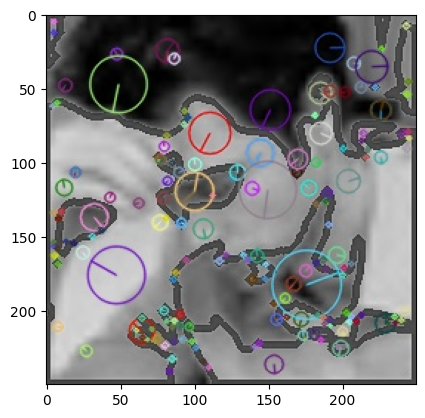

1/1 [==============================] - 0s 16ms/step
predict class: neutral


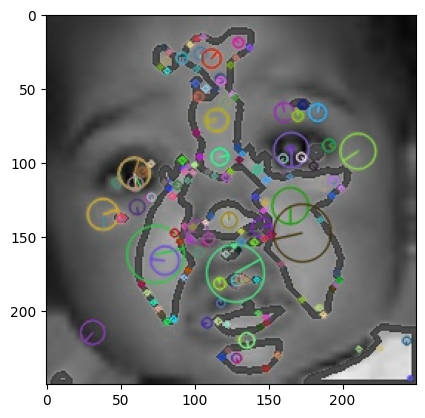

1/1 [==============================] - 0s 19ms/step
predict class: angry


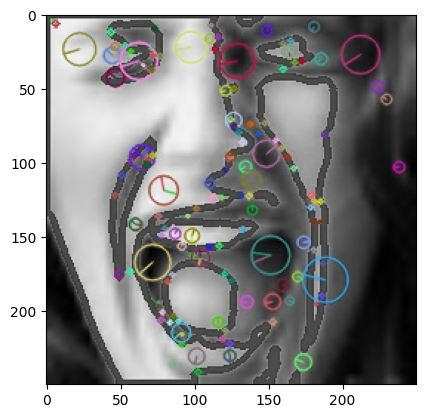

1/1 [==============================] - 0s 17ms/step
predict class: sad


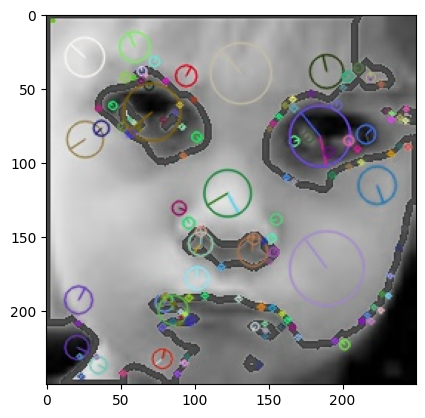

1/1 [==============================] - 0s 17ms/step
predict class: happy


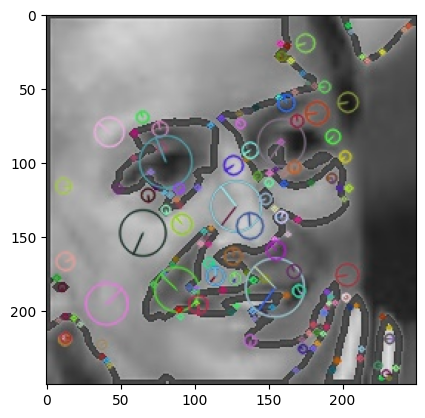

1/1 [==============================] - 0s 22ms/step
predict class: disgust


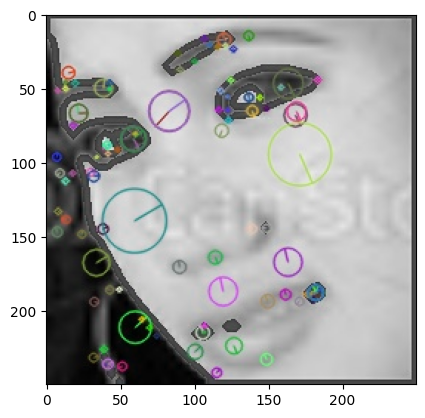

1/1 [==============================] - 0s 23ms/step
predict class: happy


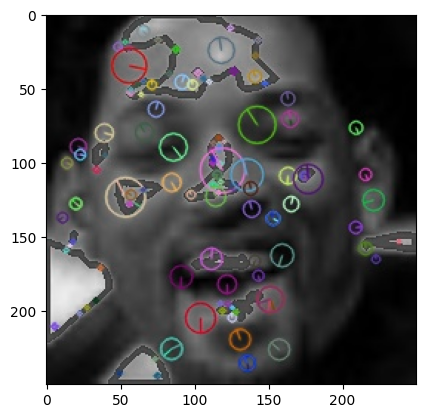

1/1 [==============================] - 0s 21ms/step
predict class: sad


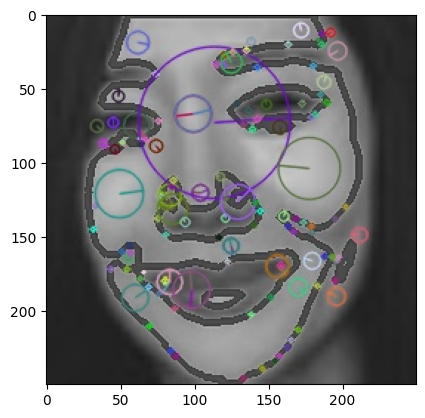

1/1 [==============================] - 0s 21ms/step
predict class: neutral


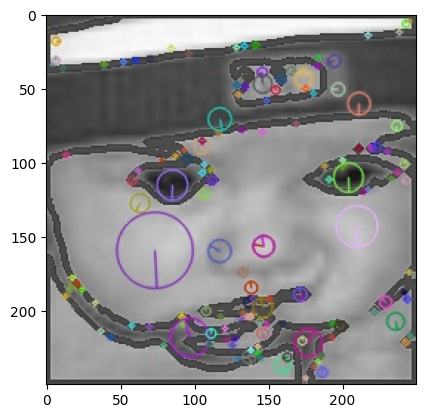

1/1 [==============================] - 0s 24ms/step
predict class: happy


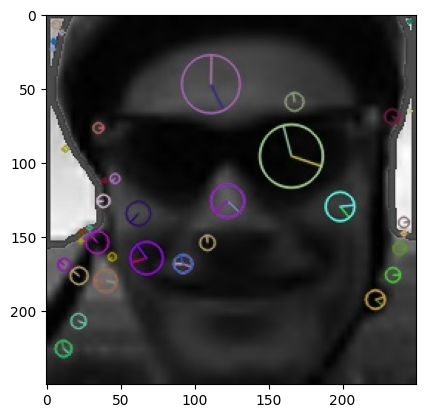

In [ ]:
from tensorflow.keras.preprocessing import image
for i in range(10):
    a = np.random.randint(7)
    b = np.random.randint(100)
    folder_path = validation + '/' + str(validation_names[a])
    image_name = [img for img in sorted(os.listdir(folder_path))]
    image_path = folder_path + '/' + image_name[b % len(image_name)]
    i1 = cv2.imread(image_path)
    img = image.load_img(image_path, target_size = (48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    img_array/=255
    y_pred = model.predict(img_array)
    prediction_class = np.argmax(y_pred)
    print("predict class:",validation_names[a])
    plt.imshow(i1)
    plt.show()

In [ ]:
#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False


#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='softmax')(X)
transfer_model = Model(base_model.input, X)


transfer_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 120, 120, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 120, 120, 32)      288       
 )                                                               
                                                              

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), verbose = 1)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 23s 1s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+00 - val_accuracy: 0.1429
Epoch 2/30
16/16 [==============================] - 25s 2s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+00 - val_accuracy: 0.1429
Epoch 3/30
16/16 [==============================] - 20s 1s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+00 - val_accuracy: 0.1429
Epoch 4/30
16/16 [==============================] - 19s 1s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+00 - val_accuracy: 0.1429
Epoch 5/30
16/16 [==============================] - 21s 1s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+00 - val_accuracy: 0.1429
Epoch 6/30
16/16 [==============================] - 20s 1s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+00 - val_accuracy: 0.1429
Epoch 7/30
16/16 [==============================] - 21s 1s/step - loss: 0.0000e+00 - accuracy: 0.1429 - val_loss: 0.0000e+0

In [ ]:
model.save('cv.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model = load_model('/content/cv.h5')
acc = model.evaluate(X_test, y_test, sample_weight=np.ones(15))
print(f'The accuracy of our model is {acc}')

1/1 [==============================] - 0s 142ms/step - loss: 45.2115 - accuracy: 0.1333
The accuracy of our model is [45.211483001708984, 0.13333334028720856]


In [ ]:
X_test = X_test[:15]

In [ ]:
y_test = y_test.reshape((-1, 7))

In [ ]:
import tensorflow as tf
X_test = tf.image.resize(X_test, (48, 48))